# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [4]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [10]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

               X1          X2          X3          X4          X5          X6  \
count  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000   
mean     0.765456  670.717427  318.699511  176.008958    5.278502    3.517915   
std      0.106609   88.806379   43.707901   45.094451    1.751195    1.111487   
min      0.620000  514.500000  245.000000  110.250000    3.500000    2.000000   
25%      0.667500  588.000000  294.000000  147.000000    3.500000    3.000000   
50%      0.760000  661.500000  318.500000  147.000000    7.000000    4.000000   
75%      0.860000  753.375000  343.000000  220.500000    7.000000    5.000000   
max      0.980000  808.500000  416.500000  220.500000    7.000000    5.000000   

               X7          X8  
count  614.000000  614.000000  
mean     0.230619    2.850163  
std      0.132822    1.570640  
min      0.000000    0.000000  
25%      0.100000    2.000000  
50%      0.250000    3.000000  
75%      0.400000    4.000000  
max      0.400

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [22]:
# Define model layers.
input_layer = Input(shape=(len(train.columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 128)          1152        input_11[0][0]                   
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 128)          16512       dense_30[0][0]                   
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 64)           8256        dense_31[0][0]                   
___________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [23]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [24]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 886us/sample - loss: 262.4987 - y1_output_loss: 120.3297 - y2_output_loss: 140.4712 - y1_output_root_mean_squared_error: 10.9977 - y2_output_root_mean_squared_error: 11.8974 - val_loss: 29.6566 - val_y1_output_loss: 11.7672 - val_y2_output_loss: 17.4185 - val_y1_output_root_mean_squared_error: 3.4678 - val_y2_output_root_mean_squared_error: 4.1989
Epoch 2/500
614/614 [==============================] - 0s 161us/sample - loss: 32.6700 - y1_output_loss: 12.2829 - y2_output_loss: 20.1109 - y1_output_root_mean_squared_error: 3.5211 - y2_output_root_mean_squared_error: 4.5025 - val_loss: 19.5548 - val_y1_output_loss: 7.6315 - val_y2_output_loss: 11.6962 - val_y1_output_root_mean_squared_error: 2.7868 - val_y2_output_root_mean_squared_error: 3.4334
Epoch 3/500
614/614 [==============================] - 0s 137us/sample - loss: 27.1578 - y1_output_loss: 10.3001 - y2_output_loss: 16.6038 - y1_

614/614 [==============================] - 0s 127us/sample - loss: 15.1402 - y1_output_loss: 5.4773 - y2_output_loss: 9.6094 - y1_output_root_mean_squared_error: 2.3330 - y2_output_root_mean_squared_error: 3.1140 - val_loss: 16.0019 - val_y1_output_loss: 6.2013 - val_y2_output_loss: 9.6076 - val_y1_output_root_mean_squared_error: 2.4944 - val_y2_output_root_mean_squared_error: 3.1273
Epoch 22/500
614/614 [==============================] - 0s 127us/sample - loss: 12.9827 - y1_output_loss: 4.9790 - y2_output_loss: 8.0022 - y1_output_root_mean_squared_error: 2.2400 - y2_output_root_mean_squared_error: 2.8223 - val_loss: 15.8722 - val_y1_output_loss: 5.0338 - val_y2_output_loss: 10.5916 - val_y1_output_root_mean_squared_error: 2.2535 - val_y2_output_root_mean_squared_error: 3.2854
Epoch 23/500
614/614 [==============================] - 0s 128us/sample - loss: 15.6759 - y1_output_loss: 5.7357 - y2_output_loss: 9.8884 - y1_output_root_mean_squared_error: 2.3919 - y2_output_root_mean_squared_

614/614 [==============================] - 0s 130us/sample - loss: 8.2899 - y1_output_loss: 2.7300 - y2_output_loss: 5.5973 - y1_output_root_mean_squared_error: 1.6503 - y2_output_root_mean_squared_error: 2.3593 - val_loss: 7.9014 - val_y1_output_loss: 2.5370 - val_y2_output_loss: 5.2049 - val_y1_output_root_mean_squared_error: 1.5943 - val_y2_output_root_mean_squared_error: 2.3151
Epoch 42/500
614/614 [==============================] - 0s 131us/sample - loss: 7.2677 - y1_output_loss: 2.3511 - y2_output_loss: 4.9131 - y1_output_root_mean_squared_error: 1.5342 - y2_output_root_mean_squared_error: 2.2168 - val_loss: 16.6598 - val_y1_output_loss: 3.8833 - val_y2_output_loss: 12.3132 - val_y1_output_root_mean_squared_error: 2.0063 - val_y2_output_root_mean_squared_error: 3.5545
Epoch 43/500
614/614 [==============================] - 0s 128us/sample - loss: 8.4506 - y1_output_loss: 2.6609 - y2_output_loss: 5.8063 - y1_output_root_mean_squared_error: 1.6299 - y2_output_root_mean_squared_erro

Epoch 62/500
614/614 [==============================] - 0s 130us/sample - loss: 4.7785 - y1_output_loss: 1.3984 - y2_output_loss: 3.3836 - y1_output_root_mean_squared_error: 1.1821 - y2_output_root_mean_squared_error: 1.8388 - val_loss: 9.7101 - val_y1_output_loss: 3.2889 - val_y2_output_loss: 6.2343 - val_y1_output_root_mean_squared_error: 1.8160 - val_y2_output_root_mean_squared_error: 2.5322
Epoch 63/500
614/614 [==============================] - 0s 131us/sample - loss: 4.6993 - y1_output_loss: 1.3930 - y2_output_loss: 3.6866 - y1_output_root_mean_squared_error: 1.1708 - y2_output_root_mean_squared_error: 1.8244 - val_loss: 22.0233 - val_y1_output_loss: 3.9267 - val_y2_output_loss: 17.5725 - val_y1_output_root_mean_squared_error: 2.0050 - val_y2_output_root_mean_squared_error: 4.2430
Epoch 64/500
614/614 [==============================] - 0s 132us/sample - loss: 6.7300 - y1_output_loss: 1.8538 - y2_output_loss: 4.8428 - y1_output_root_mean_squared_error: 1.3675 - y2_output_root_mean

Epoch 83/500
614/614 [==============================] - 0s 132us/sample - loss: 4.0334 - y1_output_loss: 0.9618 - y2_output_loss: 3.0409 - y1_output_root_mean_squared_error: 0.9844 - y2_output_root_mean_squared_error: 1.7505 - val_loss: 2.0837 - val_y1_output_loss: 0.5586 - val_y2_output_loss: 1.4744 - val_y1_output_root_mean_squared_error: 0.7459 - val_y2_output_root_mean_squared_error: 1.2359
Epoch 84/500
614/614 [==============================] - 0s 129us/sample - loss: 3.3705 - y1_output_loss: 0.9003 - y2_output_loss: 2.4618 - y1_output_root_mean_squared_error: 0.9462 - y2_output_root_mean_squared_error: 1.5733 - val_loss: 7.2467 - val_y1_output_loss: 1.7475 - val_y2_output_loss: 5.3407 - val_y1_output_root_mean_squared_error: 1.3298 - val_y2_output_root_mean_squared_error: 2.3406
Epoch 85/500
614/614 [==============================] - 0s 128us/sample - loss: 2.5429 - y1_output_loss: 0.6474 - y2_output_loss: 1.8963 - y1_output_root_mean_squared_error: 0.8020 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 130us/sample - loss: 2.7066 - y1_output_loss: 0.5513 - y2_output_loss: 2.1458 - y1_output_root_mean_squared_error: 0.7408 - y2_output_root_mean_squared_error: 1.4689 - val_loss: 2.4248 - val_y1_output_loss: 0.4677 - val_y2_output_loss: 1.8818 - val_y1_output_root_mean_squared_error: 0.6891 - val_y2_output_root_mean_squared_error: 1.3964
Epoch 105/500
614/614 [==============================] - 0s 131us/sample - loss: 1.7765 - y1_output_loss: 0.3984 - y2_output_loss: 1.4431 - y1_output_root_mean_squared_error: 0.6261 - y2_output_root_mean_squared_error: 1.1766 - val_loss: 14.1195 - val_y1_output_loss: 4.7178 - val_y2_output_loss: 9.0724 - val_y1_output_root_mean_squared_error: 2.1890 - val_y2_output_root_mean_squared_error: 3.0542
Epoch 106/500
614/614 [==============================] - 0s 134us/sample - loss: 2.4261 - y1_output_loss: 0.6112 - y2_output_loss: 1.8236 - y1_output_root_mean_squared_error: 0.7821 - y2_output_root_me

614/614 [==============================] - 0s 128us/sample - loss: 1.7710 - y1_output_loss: 0.4420 - y2_output_loss: 1.3298 - y1_output_root_mean_squared_error: 0.6643 - y2_output_root_mean_squared_error: 1.1532 - val_loss: 3.5585 - val_y1_output_loss: 0.5368 - val_y2_output_loss: 2.9275 - val_y1_output_root_mean_squared_error: 0.7345 - val_y2_output_root_mean_squared_error: 1.7375
Epoch 125/500
614/614 [==============================] - 0s 127us/sample - loss: 1.8543 - y1_output_loss: 0.4142 - y2_output_loss: 1.4254 - y1_output_root_mean_squared_error: 0.6456 - y2_output_root_mean_squared_error: 1.1990 - val_loss: 1.8685 - val_y1_output_loss: 0.4102 - val_y2_output_loss: 1.4329 - val_y1_output_root_mean_squared_error: 0.6467 - val_y2_output_root_mean_squared_error: 1.2043
Epoch 126/500
614/614 [==============================] - 0s 129us/sample - loss: 2.2553 - y1_output_loss: 0.5836 - y2_output_loss: 1.6566 - y1_output_root_mean_squared_error: 0.7676 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 128us/sample - loss: 1.5243 - y1_output_loss: 0.3415 - y2_output_loss: 1.1885 - y1_output_root_mean_squared_error: 0.5822 - y2_output_root_mean_squared_error: 1.0887 - val_loss: 1.7436 - val_y1_output_loss: 0.4077 - val_y2_output_loss: 1.3057 - val_y1_output_root_mean_squared_error: 0.6433 - val_y2_output_root_mean_squared_error: 1.1532
Epoch 146/500
614/614 [==============================] - 0s 129us/sample - loss: 1.6530 - y1_output_loss: 0.3231 - y2_output_loss: 1.3247 - y1_output_root_mean_squared_error: 0.5666 - y2_output_root_mean_squared_error: 1.1541 - val_loss: 1.5892 - val_y1_output_loss: 0.3028 - val_y2_output_loss: 1.2347 - val_y1_output_root_mean_squared_error: 0.5593 - val_y2_output_root_mean_squared_error: 1.1298
Epoch 147/500
614/614 [==============================] - 0s 128us/sample - loss: 1.9480 - y1_output_loss: 0.4967 - y2_output_loss: 1.4377 - y1_output_root_mean_squared_error: 0.7063 - y2_output_root_mea

614/614 [==============================] - 0s 132us/sample - loss: 1.4061 - y1_output_loss: 0.2806 - y2_output_loss: 1.1147 - y1_output_root_mean_squared_error: 0.5315 - y2_output_root_mean_squared_error: 1.0600 - val_loss: 1.2676 - val_y1_output_loss: 0.2148 - val_y2_output_loss: 1.0162 - val_y1_output_root_mean_squared_error: 0.4706 - val_y2_output_root_mean_squared_error: 1.0228
Epoch 166/500
614/614 [==============================] - 0s 133us/sample - loss: 1.2725 - y1_output_loss: 0.2817 - y2_output_loss: 1.0033 - y1_output_root_mean_squared_error: 0.5288 - y2_output_root_mean_squared_error: 0.9964 - val_loss: 1.9771 - val_y1_output_loss: 0.3507 - val_y2_output_loss: 1.6334 - val_y1_output_root_mean_squared_error: 0.5999 - val_y2_output_root_mean_squared_error: 1.2717
Epoch 167/500
614/614 [==============================] - 0s 128us/sample - loss: 1.3826 - y1_output_loss: 0.2918 - y2_output_loss: 1.0814 - y1_output_root_mean_squared_error: 0.5417 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 128us/sample - loss: 1.9247 - y1_output_loss: 0.4567 - y2_output_loss: 1.4623 - y1_output_root_mean_squared_error: 0.6783 - y2_output_root_mean_squared_error: 1.2102 - val_loss: 2.1712 - val_y1_output_loss: 0.2549 - val_y2_output_loss: 1.8544 - val_y1_output_root_mean_squared_error: 0.5104 - val_y2_output_root_mean_squared_error: 1.3823
Epoch 187/500
614/614 [==============================] - 0s 132us/sample - loss: 1.1003 - y1_output_loss: 0.2804 - y2_output_loss: 0.8224 - y1_output_root_mean_squared_error: 0.5299 - y2_output_root_mean_squared_error: 0.9053 - val_loss: 2.7981 - val_y1_output_loss: 0.4532 - val_y2_output_loss: 2.2999 - val_y1_output_root_mean_squared_error: 0.6843 - val_y2_output_root_mean_squared_error: 1.5264
Epoch 188/500
614/614 [==============================] - 0s 129us/sample - loss: 1.0512 - y1_output_loss: 0.2477 - y2_output_loss: 0.8054 - y1_output_root_mean_squared_error: 0.4978 - y2_output_root_mea

614/614 [==============================] - 0s 125us/sample - loss: 1.2320 - y1_output_loss: 0.2682 - y2_output_loss: 0.9696 - y1_output_root_mean_squared_error: 0.5171 - y2_output_root_mean_squared_error: 0.9821 - val_loss: 5.8718 - val_y1_output_loss: 1.9819 - val_y2_output_loss: 3.7126 - val_y1_output_root_mean_squared_error: 1.4296 - val_y2_output_root_mean_squared_error: 1.9565
Epoch 207/500
614/614 [==============================] - 0s 126us/sample - loss: 1.8181 - y1_output_loss: 0.5191 - y2_output_loss: 1.2913 - y1_output_root_mean_squared_error: 0.7218 - y2_output_root_mean_squared_error: 1.1389 - val_loss: 2.3558 - val_y1_output_loss: 0.6405 - val_y2_output_loss: 1.6444 - val_y1_output_root_mean_squared_error: 0.8120 - val_y2_output_root_mean_squared_error: 1.3025
Epoch 208/500
614/614 [==============================] - 0s 127us/sample - loss: 0.9222 - y1_output_loss: 0.2322 - y2_output_loss: 0.6968 - y1_output_root_mean_squared_error: 0.4824 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 134us/sample - loss: 1.2394 - y1_output_loss: 0.2903 - y2_output_loss: 0.9424 - y1_output_root_mean_squared_error: 0.5381 - y2_output_root_mean_squared_error: 0.9746 - val_loss: 1.1795 - val_y1_output_loss: 0.2393 - val_y2_output_loss: 0.9118 - val_y1_output_root_mean_squared_error: 0.4970 - val_y2_output_root_mean_squared_error: 0.9657
Epoch 228/500
614/614 [==============================] - 0s 133us/sample - loss: 1.2411 - y1_output_loss: 0.2909 - y2_output_loss: 0.9410 - y1_output_root_mean_squared_error: 0.5415 - y2_output_root_mean_squared_error: 0.9736 - val_loss: 1.3553 - val_y1_output_loss: 0.2149 - val_y2_output_loss: 1.0940 - val_y1_output_root_mean_squared_error: 0.4686 - val_y2_output_root_mean_squared_error: 1.0657
Epoch 229/500
614/614 [==============================] - 0s 131us/sample - loss: 1.0434 - y1_output_loss: 0.2383 - y2_output_loss: 0.7976 - y1_output_root_mean_squared_error: 0.4885 - y2_output_root_mea

614/614 [==============================] - 0s 134us/sample - loss: 0.8424 - y1_output_loss: 0.1958 - y2_output_loss: 0.6422 - y1_output_root_mean_squared_error: 0.4435 - y2_output_root_mean_squared_error: 0.8036 - val_loss: 1.2124 - val_y1_output_loss: 0.2100 - val_y2_output_loss: 0.9659 - val_y1_output_root_mean_squared_error: 0.4645 - val_y2_output_root_mean_squared_error: 0.9983
Epoch 248/500
614/614 [==============================] - 0s 134us/sample - loss: 0.7479 - y1_output_loss: 0.2234 - y2_output_loss: 0.5190 - y1_output_root_mean_squared_error: 0.4743 - y2_output_root_mean_squared_error: 0.7231 - val_loss: 1.1625 - val_y1_output_loss: 0.2344 - val_y2_output_loss: 0.8954 - val_y1_output_root_mean_squared_error: 0.4909 - val_y2_output_root_mean_squared_error: 0.9599
Epoch 249/500
614/614 [==============================] - 0s 126us/sample - loss: 0.7097 - y1_output_loss: 0.1872 - y2_output_loss: 0.5204 - y1_output_root_mean_squared_error: 0.4320 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 128us/sample - loss: 0.7137 - y1_output_loss: 0.1836 - y2_output_loss: 0.5254 - y1_output_root_mean_squared_error: 0.4296 - y2_output_root_mean_squared_error: 0.7274 - val_loss: 1.1996 - val_y1_output_loss: 0.2537 - val_y2_output_loss: 0.9073 - val_y1_output_root_mean_squared_error: 0.5115 - val_y2_output_root_mean_squared_error: 0.9685
Epoch 269/500
614/614 [==============================] - 0s 129us/sample - loss: 0.7025 - y1_output_loss: 0.1993 - y2_output_loss: 0.5025 - y1_output_root_mean_squared_error: 0.4460 - y2_output_root_mean_squared_error: 0.7096 - val_loss: 1.2789 - val_y1_output_loss: 0.2323 - val_y2_output_loss: 1.0168 - val_y1_output_root_mean_squared_error: 0.4796 - val_y2_output_root_mean_squared_error: 1.0241
Epoch 270/500
614/614 [==============================] - 0s 129us/sample - loss: 0.8216 - y1_output_loss: 0.2319 - y2_output_loss: 0.5909 - y1_output_root_mean_squared_error: 0.4832 - y2_output_root_mea

614/614 [==============================] - 0s 130us/sample - loss: 0.5973 - y1_output_loss: 0.1696 - y2_output_loss: 0.4354 - y1_output_root_mean_squared_error: 0.4132 - y2_output_root_mean_squared_error: 0.6531 - val_loss: 2.1055 - val_y1_output_loss: 0.2480 - val_y2_output_loss: 1.8090 - val_y1_output_root_mean_squared_error: 0.5052 - val_y2_output_root_mean_squared_error: 1.3603
Epoch 289/500
614/614 [==============================] - 0s 132us/sample - loss: 0.6877 - y1_output_loss: 0.1686 - y2_output_loss: 0.5201 - y1_output_root_mean_squared_error: 0.4068 - y2_output_root_mean_squared_error: 0.7227 - val_loss: 2.4476 - val_y1_output_loss: 0.6842 - val_y2_output_loss: 1.6994 - val_y1_output_root_mean_squared_error: 0.8342 - val_y2_output_root_mean_squared_error: 1.3235
Epoch 290/500
614/614 [==============================] - 0s 136us/sample - loss: 1.0831 - y1_output_loss: 0.2897 - y2_output_loss: 0.7859 - y1_output_root_mean_squared_error: 0.5399 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 135us/sample - loss: 0.6039 - y1_output_loss: 0.1661 - y2_output_loss: 0.4383 - y1_output_root_mean_squared_error: 0.4063 - y2_output_root_mean_squared_error: 0.6624 - val_loss: 1.8916 - val_y1_output_loss: 0.5727 - val_y2_output_loss: 1.2662 - val_y1_output_root_mean_squared_error: 0.7694 - val_y2_output_root_mean_squared_error: 1.1400
Epoch 310/500
614/614 [==============================] - 0s 133us/sample - loss: 0.6895 - y1_output_loss: 0.2109 - y2_output_loss: 0.4828 - y1_output_root_mean_squared_error: 0.4603 - y2_output_root_mean_squared_error: 0.6911 - val_loss: 2.9806 - val_y1_output_loss: 0.7232 - val_y2_output_loss: 2.1737 - val_y1_output_root_mean_squared_error: 0.8640 - val_y2_output_root_mean_squared_error: 1.4947
Epoch 311/500
614/614 [==============================] - 0s 133us/sample - loss: 0.6762 - y1_output_loss: 0.1984 - y2_output_loss: 0.4736 - y1_output_root_mean_squared_error: 0.4455 - y2_output_root_mea

614/614 [==============================] - 0s 130us/sample - loss: 0.5677 - y1_output_loss: 0.1472 - y2_output_loss: 0.4160 - y1_output_root_mean_squared_error: 0.3854 - y2_output_root_mean_squared_error: 0.6474 - val_loss: 0.9160 - val_y1_output_loss: 0.1854 - val_y2_output_loss: 0.7008 - val_y1_output_root_mean_squared_error: 0.4363 - val_y2_output_root_mean_squared_error: 0.8519
Epoch 330/500
614/614 [==============================] - 0s 127us/sample - loss: 0.5765 - y1_output_loss: 0.1903 - y2_output_loss: 0.3843 - y1_output_root_mean_squared_error: 0.4360 - y2_output_root_mean_squared_error: 0.6216 - val_loss: 0.9500 - val_y1_output_loss: 0.2046 - val_y2_output_loss: 0.7221 - val_y1_output_root_mean_squared_error: 0.4524 - val_y2_output_root_mean_squared_error: 0.8634
Epoch 331/500
614/614 [==============================] - 0s 129us/sample - loss: 0.5229 - y1_output_loss: 0.1475 - y2_output_loss: 0.3935 - y1_output_root_mean_squared_error: 0.3818 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 127us/sample - loss: 0.4752 - y1_output_loss: 0.1567 - y2_output_loss: 0.3210 - y1_output_root_mean_squared_error: 0.3963 - y2_output_root_mean_squared_error: 0.5640 - val_loss: 1.2716 - val_y1_output_loss: 0.2768 - val_y2_output_loss: 0.9593 - val_y1_output_root_mean_squared_error: 0.5338 - val_y2_output_root_mean_squared_error: 0.9933
Epoch 351/500
614/614 [==============================] - 0s 130us/sample - loss: 0.5886 - y1_output_loss: 0.1807 - y2_output_loss: 0.4035 - y1_output_root_mean_squared_error: 0.4264 - y2_output_root_mean_squared_error: 0.6378 - val_loss: 0.8778 - val_y1_output_loss: 0.1816 - val_y2_output_loss: 0.6763 - val_y1_output_root_mean_squared_error: 0.4330 - val_y2_output_root_mean_squared_error: 0.8309
Epoch 352/500
614/614 [==============================] - 0s 137us/sample - loss: 0.4484 - y1_output_loss: 0.1383 - y2_output_loss: 0.3096 - y1_output_root_mean_squared_error: 0.3717 - y2_output_root_mea

614/614 [==============================] - 0s 129us/sample - loss: 0.4887 - y1_output_loss: 0.1586 - y2_output_loss: 0.3272 - y1_output_root_mean_squared_error: 0.3989 - y2_output_root_mean_squared_error: 0.5741 - val_loss: 0.8973 - val_y1_output_loss: 0.1775 - val_y2_output_loss: 0.6932 - val_y1_output_root_mean_squared_error: 0.4262 - val_y2_output_root_mean_squared_error: 0.8459
Epoch 371/500
614/614 [==============================] - 0s 130us/sample - loss: 0.7137 - y1_output_loss: 0.1971 - y2_output_loss: 0.5135 - y1_output_root_mean_squared_error: 0.4448 - y2_output_root_mean_squared_error: 0.7182 - val_loss: 1.1573 - val_y1_output_loss: 0.2216 - val_y2_output_loss: 0.9250 - val_y1_output_root_mean_squared_error: 0.4743 - val_y2_output_root_mean_squared_error: 0.9656
Epoch 372/500
614/614 [==============================] - 0s 130us/sample - loss: 0.5400 - y1_output_loss: 0.1733 - y2_output_loss: 0.3625 - y1_output_root_mean_squared_error: 0.4176 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 127us/sample - loss: 0.3870 - y1_output_loss: 0.1242 - y2_output_loss: 0.2635 - y1_output_root_mean_squared_error: 0.3530 - y2_output_root_mean_squared_error: 0.5122 - val_loss: 0.9866 - val_y1_output_loss: 0.2354 - val_y2_output_loss: 0.7190 - val_y1_output_root_mean_squared_error: 0.4919 - val_y2_output_root_mean_squared_error: 0.8629
Epoch 392/500
614/614 [==============================] - 0s 127us/sample - loss: 0.5600 - y1_output_loss: 0.1492 - y2_output_loss: 0.4067 - y1_output_root_mean_squared_error: 0.3874 - y2_output_root_mean_squared_error: 0.6403 - val_loss: 0.9095 - val_y1_output_loss: 0.2051 - val_y2_output_loss: 0.6898 - val_y1_output_root_mean_squared_error: 0.4597 - val_y2_output_root_mean_squared_error: 0.8355
Epoch 393/500
614/614 [==============================] - 0s 127us/sample - loss: 0.6102 - y1_output_loss: 0.1896 - y2_output_loss: 0.4306 - y1_output_root_mean_squared_error: 0.4269 - y2_output_root_mea

614/614 [==============================] - 0s 130us/sample - loss: 0.4486 - y1_output_loss: 0.1464 - y2_output_loss: 0.3004 - y1_output_root_mean_squared_error: 0.3841 - y2_output_root_mean_squared_error: 0.5488 - val_loss: 1.0152 - val_y1_output_loss: 0.2339 - val_y2_output_loss: 0.7573 - val_y1_output_root_mean_squared_error: 0.4911 - val_y2_output_root_mean_squared_error: 0.8798
Epoch 412/500
614/614 [==============================] - 0s 128us/sample - loss: 0.3455 - y1_output_loss: 0.1179 - y2_output_loss: 0.2280 - y1_output_root_mean_squared_error: 0.3436 - y2_output_root_mean_squared_error: 0.4769 - val_loss: 0.9104 - val_y1_output_loss: 0.1836 - val_y2_output_loss: 0.6997 - val_y1_output_root_mean_squared_error: 0.4346 - val_y2_output_root_mean_squared_error: 0.8494
Epoch 413/500
614/614 [==============================] - 0s 127us/sample - loss: 0.3960 - y1_output_loss: 0.1285 - y2_output_loss: 0.2675 - y1_output_root_mean_squared_error: 0.3577 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 129us/sample - loss: 0.3979 - y1_output_loss: 0.1168 - y2_output_loss: 0.2807 - y1_output_root_mean_squared_error: 0.3425 - y2_output_root_mean_squared_error: 0.5297 - val_loss: 1.0235 - val_y1_output_loss: 0.2008 - val_y2_output_loss: 0.7954 - val_y1_output_root_mean_squared_error: 0.4477 - val_y2_output_root_mean_squared_error: 0.9072
Epoch 433/500
614/614 [==============================] - 0s 131us/sample - loss: 0.3735 - y1_output_loss: 0.1221 - y2_output_loss: 0.2522 - y1_output_root_mean_squared_error: 0.3491 - y2_output_root_mean_squared_error: 0.5016 - val_loss: 0.9982 - val_y1_output_loss: 0.1539 - val_y2_output_loss: 0.8174 - val_y1_output_root_mean_squared_error: 0.3960 - val_y2_output_root_mean_squared_error: 0.9173
Epoch 434/500
614/614 [==============================] - 0s 129us/sample - loss: 0.3295 - y1_output_loss: 0.1173 - y2_output_loss: 0.2121 - y1_output_root_mean_squared_error: 0.3411 - y2_output_root_mea

614/614 [==============================] - 0s 129us/sample - loss: 0.4886 - y1_output_loss: 0.1458 - y2_output_loss: 0.3396 - y1_output_root_mean_squared_error: 0.3825 - y2_output_root_mean_squared_error: 0.5851 - val_loss: 1.0139 - val_y1_output_loss: 0.2237 - val_y2_output_loss: 0.7748 - val_y1_output_root_mean_squared_error: 0.4711 - val_y2_output_root_mean_squared_error: 0.8899
Epoch 453/500
614/614 [==============================] - 0s 128us/sample - loss: 0.3154 - y1_output_loss: 0.1099 - y2_output_loss: 0.2074 - y1_output_root_mean_squared_error: 0.3313 - y2_output_root_mean_squared_error: 0.4535 - val_loss: 0.8479 - val_y1_output_loss: 0.1716 - val_y2_output_loss: 0.6508 - val_y1_output_root_mean_squared_error: 0.4166 - val_y2_output_root_mean_squared_error: 0.8212
Epoch 454/500
614/614 [==============================] - 0s 126us/sample - loss: 0.4148 - y1_output_loss: 0.1273 - y2_output_loss: 0.2854 - y1_output_root_mean_squared_error: 0.3576 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 129us/sample - loss: 0.4195 - y1_output_loss: 0.1342 - y2_output_loss: 0.2846 - y1_output_root_mean_squared_error: 0.3669 - y2_output_root_mean_squared_error: 0.5338 - val_loss: 1.4719 - val_y1_output_loss: 0.3153 - val_y2_output_loss: 1.1113 - val_y1_output_root_mean_squared_error: 0.5689 - val_y2_output_root_mean_squared_error: 1.0716
Epoch 474/500
614/614 [==============================] - 0s 126us/sample - loss: 0.4315 - y1_output_loss: 0.1295 - y2_output_loss: 0.3042 - y1_output_root_mean_squared_error: 0.3612 - y2_output_root_mean_squared_error: 0.5487 - val_loss: 1.3178 - val_y1_output_loss: 0.2040 - val_y2_output_loss: 1.0849 - val_y1_output_root_mean_squared_error: 0.4593 - val_y2_output_root_mean_squared_error: 1.0521
Epoch 475/500
614/614 [==============================] - 0s 130us/sample - loss: 0.3085 - y1_output_loss: 0.1091 - y2_output_loss: 0.1992 - y1_output_root_mean_squared_error: 0.3302 - y2_output_root_mea

614/614 [==============================] - 0s 131us/sample - loss: 0.3119 - y1_output_loss: 0.1124 - y2_output_loss: 0.1984 - y1_output_root_mean_squared_error: 0.3341 - y2_output_root_mean_squared_error: 0.4475 - val_loss: 0.7927 - val_y1_output_loss: 0.1851 - val_y2_output_loss: 0.5948 - val_y1_output_root_mean_squared_error: 0.4330 - val_y2_output_root_mean_squared_error: 0.7779
Epoch 494/500
614/614 [==============================] - 0s 134us/sample - loss: 0.3247 - y1_output_loss: 0.1087 - y2_output_loss: 0.2140 - y1_output_root_mean_squared_error: 0.3303 - y2_output_root_mean_squared_error: 0.4644 - val_loss: 0.7560 - val_y1_output_loss: 0.1599 - val_y2_output_loss: 0.5763 - val_y1_output_root_mean_squared_error: 0.4053 - val_y2_output_root_mean_squared_error: 0.7692
Epoch 495/500
614/614 [==============================] - 0s 130us/sample - loss: 0.3051 - y1_output_loss: 0.1192 - y2_output_loss: 0.1855 - y1_output_root_mean_squared_error: 0.3458 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [25]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 34us/sample - loss: 1.2593 - y1_output_loss: 0.2039 - y2_output_loss: 1.0539 - y1_output_root_mean_squared_error: 0.4443 - y2_output_root_mean_squared_error: 1.0305
Loss = 1.259251034104979, Y1_loss = 0.203907772898674, Y1_mse = 0.44428423047065735, Y2_loss = 1.0538990497589111, Y2_mse = 1.03046715259552


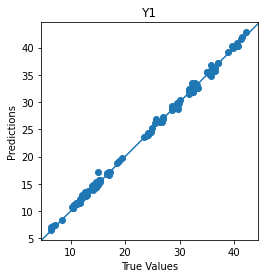

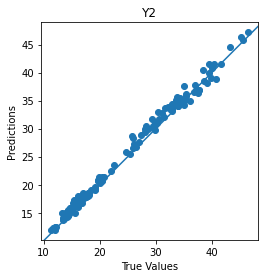

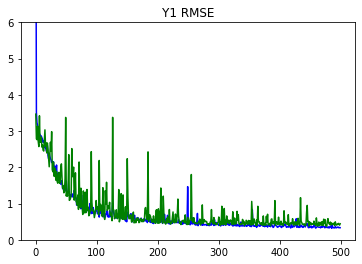

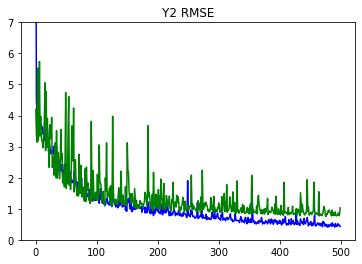

In [26]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)